In [1]:
!pip install gdown

# Importing Libraries

In [2]:
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset

from transformers import AdamW, BertTokenizer, BertModel, Trainer, TrainingArguments, get_scheduler

# Importing Data

In [3]:
gdown.download("https://drive.google.com/uc?id=1UaYztrYKffzDcvgCRQMT7c4I6HrLloDm", '/kaggle/working/com.csv', quiet=False)
print('/kaggle/working/data.csv')

Downloading...
From: https://drive.google.com/uc?id=1UaYztrYKffzDcvgCRQMT7c4I6HrLloDm
To: /kaggle/working/com.csv
100%|██████████| 430k/430k [00:00<00:00, 101MB/s]

/kaggle/working/data.csv


In [4]:
com = pd.read_csv("/kaggle/working/com.csv")
com.head()

,text,comp,en1,en2
0,لابتوب اسوس افضل من لابتوبات ابل ؟ احس مستحيل ...,1,اسوس,ابل
1,اسوس افضل من وجهة نظري,1,اسوس,NaN
2,كلهم نفس المواصفات مافي فرق اسوس افضل من hp في...,1,اسوس,hp
3,التخصصات الهندسية بالذات الحاسب والبرمجيات ماي...,1,اسوس,NaN
4,اسوس افضل من ناحية التنوع والاسعار والعروض,1,اسوس,NaN


# Data Preprocessing

In [5]:
train_df, test_df = train_test_split(com, test_size=0.2, random_state=42)

In [6]:
tokenizer = BertTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02-twitter")

tokenizer_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/751k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

In [7]:
max_length = max(len(tokenizer(text)["input_ids"]) for text in com['text'])
max_length

107

In [8]:
# Function to split en1 or en2 values and handle "nan" string values
def split_values(val):
    if pd.isna(val) or val == "nan":  # Check if value is NaN or "nan" string
        return []
    return [item.strip() for item in re.split(r'[ ,]+', val) if item.strip()]

# Tokenization function for text with labels for en1 and en2
def tokenize_data(example):
    text = example["text"]
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=max_length)

    # Generate labels
    labels = [0] * len(tokens["input_ids"])  # Default label for non-entity tokens

    # Process and tokenize en1 and en2 entities
    en1_entities = split_values(example["en1"])
    en2_entities = split_values(example["en2"])

    en1_tokens = [tokenizer.tokenize(entity) for entity in en1_entities]
    en2_tokens = [tokenizer.tokenize(entity) for entity in en2_entities]

    # Match tokens and assign labels
    for i, token_id in enumerate(tokens["input_ids"]):
        token_str = tokenizer.convert_ids_to_tokens([token_id])[0]
        for entity_tokens in en1_tokens:
            if token_str in entity_tokens:
                labels[i] = 1  # Label for en1
        for entity_tokens in en2_tokens:
            if token_str in entity_tokens:
                labels[i] = 2  # Label for en2

    tokens["label"] = labels
    return tokens

In [9]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [10]:
train_dataset = train_dataset.map(tokenize_data, batched=False)
test_dataset = test_dataset.map(tokenize_data, batched=False)

Map:   0%|          | 0/1861 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

In [11]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [12]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# AraBERT + LSTM

In [13]:
class BertLSTMForNER(nn.Module):
    def __init__(self, model_name, hidden_size=768, lstm_hidden_size=256, num_labels=3, dropout_rate=0.5):
        super(BertLSTMForNER, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.lstm = nn.LSTM(input_size=hidden_size, 
                            hidden_size=lstm_hidden_size,
                            batch_first=True, 
                            bidirectional=True)
        self.classifier = nn.Linear(lstm_hidden_size * 2, num_labels)  # *2 for bidirectional LSTM
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)        
        lstm_output, _ = self.lstm(sequence_output)  # Shape: (batch_size, seq_length, lstm_hidden_size * 2)
        lstm_output = self.dropout(lstm_output)
        logits = self.classifier(lstm_output)  # Shape: (batch_size, seq_length, num_labels)
        return logits

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model_name = "aubmindlab/bert-base-arabertv02-twitter"
model = BertLSTMForNER(model_name, num_labels=3).to(device)

config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
for param in model.parameters():
    param.requires_grad = False

for param in model.bert.encoder.layer[-2:].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

In [17]:
epochs = 20

In [18]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = get_scheduler("cosine", optimizer, num_warmup_steps=0, 
                           num_training_steps=len(train_loader) * epochs)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []
learning_rates = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print("-" * 30)
    
    # Training Phase
    model.train()
    train_loss = 0
    train_preds, train_labels = [], []

    for batch in train_loader:
        optimizer.zero_grad()

        # Move data to the device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Compute loss
        loss = criterion(logits.view(-1, 3), labels.view(-1))
        train_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Store learning rate
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Collect predictions and true labels for F1 score
        preds = torch.argmax(logits, dim=-1).view(-1).cpu().numpy()
        labels = labels.view(-1).cpu().numpy()
        mask = labels != -100  # Ignore padding tokens
        train_preds.extend(preds[mask])
        train_labels.extend(labels[mask])

    avg_train_loss = train_loss / len(train_loader)
    train_f1 = f1_score(train_labels, train_preds, average="macro")
    train_losses.append(avg_train_loss)
    train_f1_scores.append(train_f1)

    # Validation Phase
    model.eval()
    test_loss = 0
    test_preds, test_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Compute loss
            loss = criterion(logits.view(-1, 3), labels.view(-1))
            test_loss += loss.item()

            # Collect predictions and true labels for F1 score
            preds = torch.argmax(logits, dim=-1).view(-1).cpu().numpy()
            labels = labels.view(-1).cpu().numpy()
            mask = labels != -100  # Ignore padding tokens
            test_preds.extend(preds[mask])
            test_labels.extend(labels[mask])

    avg_test_loss = test_loss / len(test_loader)
    test_f1 = f1_score(test_labels, test_preds, average="macro")
    test_losses.append(avg_test_loss)
    test_f1_scores.append(test_f1)

    print(f"Train Loss: {avg_train_loss:.4f}, Train F1: {train_f1:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test F1: {test_f1:.4f}")
    print()

Epoch 1/20
------------------------------
Train Loss: 0.2029, Train F1: 0.3382
Test Loss: 0.0835, Test F1: 0.5137

Epoch 2/20
------------------------------
Train Loss: 0.0683, Train F1: 0.6688
Test Loss: 0.0500, Test F1: 0.8592

Epoch 3/20
------------------------------
Train Loss: 0.0489, Train F1: 0.8231
Test Loss: 0.0384, Test F1: 0.8820

Epoch 4/20
------------------------------
Train Loss: 0.0389, Train F1: 0.8693
Test Loss: 0.0322, Test F1: 0.8801

Epoch 5/20
------------------------------
Train Loss: 0.0334, Train F1: 0.8809
Test Loss: 0.0280, Test F1: 0.8939

Epoch 6/20
------------------------------
Train Loss: 0.0302, Train F1: 0.8862
Test Loss: 0.0268, Test F1: 0.8966

Epoch 7/20
------------------------------
Train Loss: 0.0278, Train F1: 0.8958
Test Loss: 0.0251, Test F1: 0.9053

Epoch 8/20
------------------------------
Train Loss: 0.0262, Train F1: 0.8996
Test Loss: 0.0250, Test F1: 0.9002

Epoch 9/20
------------------------------
Train Loss: 0.0246, Train F1: 0.9025
T

# Evaluation

In [20]:
# Compute metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average="macro")
test_recall = recall_score(test_labels, test_preds, average="macro")
test_f1 = f1_score(test_labels, test_preds, average="macro")

# Print metrics
print(f"Test Accuracy: {test_accuracy:.5f}")
print(f"Test Precision: {test_precision:.5f}")
print(f"Test Recall: {test_recall:.5f}")
print(f"Test F1 Score: {test_f1:.5f}")

Test Accuracy: 0.99248
Test Precision: 0.90233
Test Recall: 0.90904
Test F1 Score: 0.90564


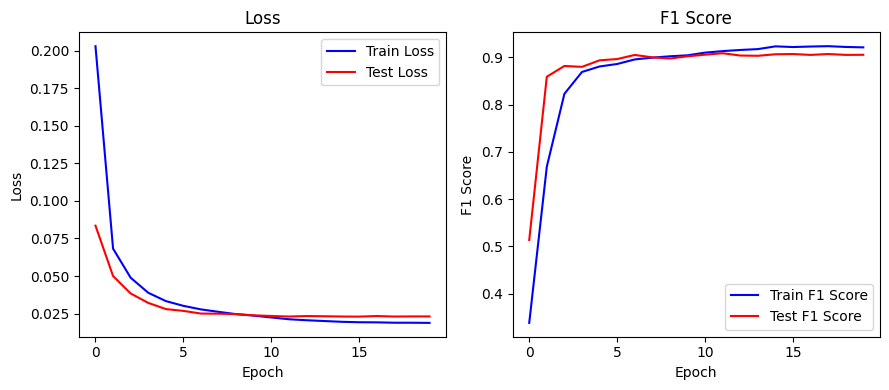

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Plot Loss
axes[0].plot(range(len(train_losses)), train_losses, label='Train Loss', color='blue')
axes[0].plot(range(len(test_losses)), test_losses, label='Test Loss', color='red')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot F1 Score
axes[1].plot(range(len(train_f1_scores)), train_f1_scores, label='Train F1 Score', color='blue')
axes[1].plot(range(len(test_f1_scores)), test_f1_scores, label='Test F1 Score', color='red')
axes[1].set_title('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].legend()

plt.tight_layout()
plt.show()

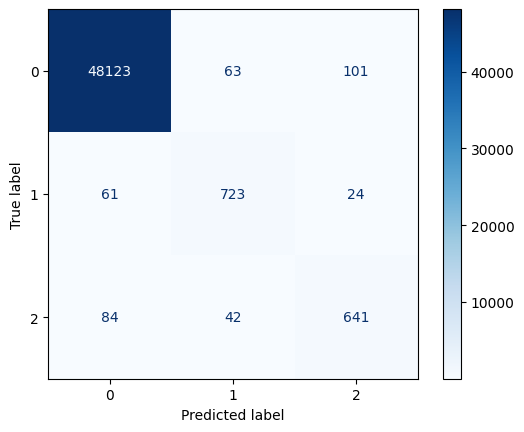

In [22]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Saving Models

In [23]:
tokenizer.save_pretrained("tokenizer_n")

('tokenizer_n/tokenizer_config.json',
 'tokenizer_n/special_tokens_map.json',
 'tokenizer_n/vocab.txt',
 'tokenizer_n/added_tokens.json')

In [24]:
torch.save(model.state_dict(), "model_n.pth")

In [25]:
!zip -r deployment_files_n.zip model_n.pth tokenizer_n

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: model_n.pth (deflated 7%)
  adding: tokenizer_n/ (stored 0%)
  adding: tokenizer_n/vocab.txt (deflated 64%)
  adding: tokenizer_n/special_tokens_map.json (deflated 80%)
  adding: tokenizer_n/tokenizer_config.json (deflated 72%)
